# 버스 2

인사이트와 피쳐엔지니어링을 했지만, 값이 더 안좋거나 변화가 없었다.

## 0.준비

- GPU 학습

    - 런타임 - 런타임 유형 변경 - GPU

    - 아래 셀 실행 후 런타임 다시시작, 런타임 모두 실행

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install catboost

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

import folium

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/버스/train (1).csv')
test = pd.read_csv('/content/drive/MyDrive/버스/test (1).csv')
submission = pd.read_csv('/content/drive/MyDrive/버스/sample_submission (1).csv')

In [ ]:
train['next_arrive_time'].value_counts()

44      5704
42      5693
46      5624
40      5464
50      5342
        ... 
2046       1
1624       1
1016       1
1442       1
1392       1
Name: next_arrive_time, Length: 596, dtype: int64

(array([2.07537e+05, 2.48600e+03, 2.08000e+02, 7.30000e+01, 3.70000e+01,
        3.40000e+01, 2.00000e+01, 3.00000e+01, 1.60000e+01, 1.60000e+01]),
 array([   6.,  305.,  604.,  903., 1202., 1501., 1800., 2099., 2398.,
        2697., 2996.]),
 <a list of 10 Patch objects>)

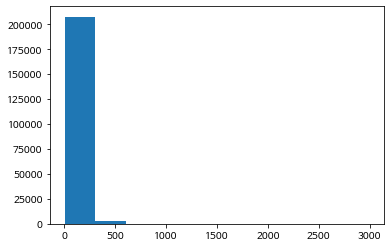

In [ ]:
plt.hist(train['next_arrive_time'])

## 1.EDA - feature

In [ ]:
train

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,33.255783,126.577450,비석거리,21시,528.0,삼아아파트,33.251896,126.574417,96
210453,210453,2019-10-28,405328102,7983486,281-2,33.248595,126.568527,동문로터리,21시,280.0,매일올레시장 7번입구,33.249753,126.565959,50
210454,210454,2019-10-28,405328102,7983486,281-2,33.251891,126.560303,서귀포시 구 버스터미널,21시,114.0,아랑조을거리 입구,33.251084,126.559551,16
210455,210455,2019-10-28,405328102,7983486,281-2,33.251084,126.559551,아랑조을거리 입구,21시,223.0,평생학습관,33.249504,126.558068,38


### 1) route_id	/ vh_id	/ route_nm

- vh_id를 알면 route_id, route_nm을 알 수 있다

In [ ]:
train[train['route_id'] == 405136001]['route_nm'].unique()

array(['360-1'], dtype=object)

In [ ]:
train[train['route_nm'] == '360-1']['route_id'].unique()

array([405136001])

In [ ]:
train[train['vh_id'] == 7997025]['route_id'].unique()

array([405136001])

In [ ]:
train[train['vh_id'] == 7997025]['route_nm'].unique()

array(['360-1'], dtype=object)

In [ ]:
def check(text:str):
  if (len(train[train['vh_id'] == text]['route_id'].unique()) != 1) | (len(train[train['vh_id'] == text]['route_nm'].unique()) != 1):
    return True
  else :
    return False

temp = list(map(check, train['vh_id'].unique()))
set(temp)

{False}

- 서로 하나씩밖에 없기때문에 route_id	vh_id	route_nm	now 이중 하나만 사용해도된다.

가장 많은 데이터를 가지고 있는 vh_id를 사용

버스의 아이디만 알면 버스경로와 몇번인지를 알 수 있다.

루트넘버만알면 버스아이디를 알기는 어렵기 때문

### 2) gps feature

In [ ]:
train[150:200]

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
150,150,2019-10-15,405136001,7997025,360-1,33.485854,126.480530,노형오거리,20시,252.0,남녕고등학교,33.488046,126.483112,182
151,151,2019-10-15,405136001,7997025,360-1,33.488046,126.483112,남녕고등학교,20시,322.0,한라병원,33.489633,126.486000,132
152,152,2019-10-15,405136001,7997025,360-1,33.489633,126.486000,한라병원,20시,291.0,삼무공원사거리,33.489900,126.488917,148
153,153,2019-10-15,405136001,7997025,360-1,33.489900,126.488917,삼무공원사거리,20시,381.0,제원아파트,33.487531,126.489892,146
154,154,2019-10-15,405136001,7997025,360-1,33.487531,126.489892,제원아파트,21시,267.0,은남동,33.485822,126.490897,68
155,155,2019-10-15,405136001,7997025,360-1,33.485822,126.490897,은남동,21시,374.0,도호동,33.485662,126.494923,74
156,156,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,21시,321.0,연동주민센터,33.487317,126.496617,60
157,157,2019-10-15,405136001,7997025,360-1,33.487317,126.496617,연동주민센터,21시,455.0,제주도청 신제주로터리,33.491433,126.496783,98
158,158,2019-10-15,405136001,7997025,360-1,33.491433,126.496783,제주도청 신제주로터리,21시,528.0,연동입구,33.496203,126.496995,164
159,159,2019-10-15,405136001,7997025,360-1,33.496203,126.496995,연동입구,21시,753.0,오라3동,33.499250,126.503183,94


In [ ]:
train['temp'] = train['vh_id'].shift(-1) #한칸씩 당기기
train

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,temp
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24,7997025.0
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36,7997025.0
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40,7997025.0
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,7997025.0
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64,7997025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,33.255783,126.577450,비석거리,21시,528.0,삼아아파트,33.251896,126.574417,96,7983486.0
210453,210453,2019-10-28,405328102,7983486,281-2,33.248595,126.568527,동문로터리,21시,280.0,매일올레시장 7번입구,33.249753,126.565959,50,7983486.0
210454,210454,2019-10-28,405328102,7983486,281-2,33.251891,126.560303,서귀포시 구 버스터미널,21시,114.0,아랑조을거리 입구,33.251084,126.559551,16,7983486.0
210455,210455,2019-10-28,405328102,7983486,281-2,33.251084,126.559551,아랑조을거리 입구,21시,223.0,평생학습관,33.249504,126.558068,38,7983486.0


In [ ]:
train[150:200]

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,temp
150,150,2019-10-15,405136001,7997025,360-1,33.485854,126.480530,노형오거리,20시,252.0,남녕고등학교,33.488046,126.483112,182,7997025.0
151,151,2019-10-15,405136001,7997025,360-1,33.488046,126.483112,남녕고등학교,20시,322.0,한라병원,33.489633,126.486000,132,7997025.0
152,152,2019-10-15,405136001,7997025,360-1,33.489633,126.486000,한라병원,20시,291.0,삼무공원사거리,33.489900,126.488917,148,7997025.0
153,153,2019-10-15,405136001,7997025,360-1,33.489900,126.488917,삼무공원사거리,20시,381.0,제원아파트,33.487531,126.489892,146,7997025.0
154,154,2019-10-15,405136001,7997025,360-1,33.487531,126.489892,제원아파트,21시,267.0,은남동,33.485822,126.490897,68,7997025.0
155,155,2019-10-15,405136001,7997025,360-1,33.485822,126.490897,은남동,21시,374.0,도호동,33.485662,126.494923,74,7997025.0
156,156,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,21시,321.0,연동주민센터,33.487317,126.496617,60,7997025.0
157,157,2019-10-15,405136001,7997025,360-1,33.487317,126.496617,연동주민센터,21시,455.0,제주도청 신제주로터리,33.491433,126.496783,98,7997025.0
158,158,2019-10-15,405136001,7997025,360-1,33.491433,126.496783,제주도청 신제주로터리,21시,528.0,연동입구,33.496203,126.496995,164,7997025.0
159,159,2019-10-15,405136001,7997025,360-1,33.496203,126.496995,연동입구,21시,753.0,오라3동,33.499250,126.503183,94,7997025.0


In [ ]:
idx = [-1]
idx = idx + list(train[train['vh_id'] != train['temp']]['id'].values)

In [ ]:
idx

[-1,
 180,
 380,
 538,
 716,
 901,
 1086,
 1265,
 1421,
 1591,
 1780,
 1838,
 2050,
 2227,
 2408,
 2567,
 2763,
 2967,
 3145,
 3361,
 3566,
 3599,
 3782,
 3977,
 4161,
 4360,
 4529,
 4719,
 4919,
 5079,
 5234,
 5398,
 5592,
 5787,
 5967,
 6144,
 6298,
 6449,
 6656,
 6841,
 7098,
 7273,
 7497,
 7665,
 7825,
 7935,
 8209,
 8472,
 8718,
 8940,
 9146,
 9283,
 9491,
 9653,
 9910,
 10139,
 10334,
 10522,
 10775,
 10984,
 11172,
 11327,
 11543,
 11729,
 11858,
 11946,
 12038,
 12109,
 12181,
 12293,
 12401,
 12487,
 12591,
 12677,
 12856,
 12860,
 13011,
 13146,
 13299,
 13461,
 13639,
 13806,
 13952,
 14117,
 14281,
 14464,
 14630,
 14777,
 14789,
 14823,
 14964,
 15087,
 15220,
 15390,
 15536,
 15667,
 15848,
 15979,
 16167,
 16343,
 16531,
 16724,
 16908,
 17092,
 17206,
 17388,
 17578,
 17635,
 17815,
 17976,
 18170,
 18269,
 18454,
 18673,
 18892,
 19099,
 19283,
 19472,
 19612,
 19746,
 19914,
 20067,
 20225,
 20410,
 20601,
 20745,
 20907,
 21059,
 21227,
 21347,
 21525,
 21723,
 21910

In [ ]:
train.loc[idx[2]+1:idx[3]]

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,temp
381,381,2019-10-15,405136001,7997035,360-1,33.479705,126.543811,남국원(아라방면),07시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,7997035.0
382,382,2019-10-15,405136001,7997035,360-1,33.493109,126.535091,제주지방법원(아라방면),07시,414.0,고산동산(아라방면),33.496007,126.532287,144,7997035.0
383,383,2019-10-15,405136001,7997035,360-1,33.478867,126.483833,한라중학교/부영아파트,08시,417.0,대림2차아파트,33.478850,126.488350,116,7997035.0
384,384,2019-10-15,405136001,7997035,360-1,33.478850,126.488350,대림2차아파트,08시,334.0,연동대림1차아파트,33.480700,126.489933,42,7997035.0
385,385,2019-10-15,405136001,7997035,360-1,33.480700,126.489933,연동대림1차아파트,08시,550.0,케이티앤지,33.482077,126.485355,174,7997035.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,534,2019-10-15,405136001,7997035,360-1,33.493109,126.535091,제주지방법원(아라방면),22시,525.0,제주중앙여자고등학교(아라방면),33.489414,126.538642,116,7997035.0
535,535,2019-10-15,405136001,7997035,360-1,33.489414,126.538642,제주중앙여자고등학교(아라방면),22시,642.0,제주여자중고등학교(아라방면),33.484860,126.542928,52,7997035.0
536,536,2019-10-15,405136001,7997035,360-1,33.484860,126.542928,제주여자중고등학교(아라방면),22시,578.0,남국원(아라방면),33.479705,126.543811,76,7997035.0
537,537,2019-10-15,405136001,7997035,360-1,33.456267,126.551750,제주대학교입구,22시,266.0,제대마을,33.457724,126.554014,20,7997035.0


In [ ]:
import folium

my_idx = 700

center = [((train[['now_latitude',	'now_longitude']].loc[1].values[0])+(train[['now_latitude',	'now_longitude']].loc[len(train)-1].values[0]))/2, 
          ((train[['now_latitude',	'now_longitude']].loc[1].values[1])+(train[['now_latitude',	'now_longitude']].loc[len(train)-1].values[1]))/2]

m = folium.Map(location=center, zoom_start=11)

locations = train.loc[idx[my_idx]+1:idx[my_idx+1]][['next_latitude', 'next_longitude']].values

folium.PolyLine(locations=locations).add_to(m)

m

### 3) station

#### a) 역 이름이 같으면 좌표도 같을까?

In [ ]:
pd.DataFrame(train.groupby(['now_station', 'now_latitude']).count().reset_index()[:50].value_counts('now_station'))

,0
now_station,
911의원,2
고성리제주은행,2
구좌중앙초등학교,2
구좌보건지소,2
교래입구,2
광치기해변,2
광지동,2
광대왓,2
관덕정,2


In [ ]:
train[train['now_station'] == '911의원']['now_latitude'].unique()

array([33.540617, 33.540685])

#### b) 좌표로 역 이름을 알 수 있을까?

- longitude를 알면 역 이름을 알 수 있다

In [ ]:
def check_station(text:str):
  if len(train[train['now_latitude'] == text]['now_station'].unique()) != 1:
    return True
  else :
    return False

In [ ]:
train[train['now_latitude'] == train['now_latitude'].unique()[3]]['now_station'].unique()

array(['남국원(아라방면)'], dtype=object)

In [ ]:
temp = list(map(check_station, train['now_latitude'].unique()))
set(temp)

{False, True}

In [ ]:
# 좌표로 역이름을 알 수 없는 애들

train['now_latitude'].unique()[temp]

array([33.275267, 33.274958, 33.4523  , 33.248487])

In [ ]:
train[train['now_latitude'] == train['now_latitude'].unique()[temp][3]]

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,temp
6777,6777,2019-10-15,405320111,7983041,201-11,33.248487,126.512302,고래왓,12시,607.0,서귀포버스터미널,33.248726,126.508138,124,7983041.0
7394,7394,2019-10-15,405320112,7983063,201-12,33.248487,126.511195,대륜동주민센터,14시,189.0,서귀포버스터미널(가상정류소),33.249091,126.509224,46,7983063.0
7786,7786,2019-10-15,405320112,7983095,201-12,33.248487,126.511195,대륜동주민센터,15시,189.0,서귀포버스터미널(가상정류소),33.249091,126.509224,26,7983095.0
7839,7839,2019-10-15,405320112,7983224,201-12,33.248487,126.511195,대륜동주민센터,09시,329.0,고래왓,33.247942,126.514688,34,7983224.0
8177,8177,2019-10-15,405320113,7983075,201-13,33.248487,126.512302,고래왓,18시,607.0,서귀포버스터미널,33.248726,126.508138,228,7983075.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210111,210111,2019-10-28,405328102,7983445,281-2,33.248487,126.511195,대륜동주민센터,18시,329.0,고래왓,33.247942,126.514688,34,7983445.0
210151,210151,2019-10-28,405328102,7983445,281-2,33.248487,126.511195,대륜동주민센터,22시,189.0,서귀포버스터미널(가상정류소),33.249091,126.509224,20,7983445.0
210162,210162,2019-10-28,405328102,7983485,281-2,33.248487,126.511195,대륜동주민센터,08시,189.0,서귀포버스터미널(가상정류소),33.249091,126.509224,38,7983485.0
210212,210212,2019-10-28,405328102,7983485,281-2,33.248487,126.511195,대륜동주민센터,13시,189.0,서귀포버스터미널(가상정류소),33.249091,126.509224,20,7983485.0


In [ ]:
def check_station(text:str):
  if len(train[train['now_longitude'] == text]['now_station'].unique()) != 1:
    return True
  else :
    return False

In [ ]:
temp = list(map(check_station, train['now_longitude'].unique()))
set(temp)

{False}

In [ ]:
train['now_longitude'].unique()[temp]

array([], dtype=float64)

In [ ]:
def check_station(text:str):
  if len(train[train['next_longitude'] == text]['next_station'].unique()) != 1:
    return True
  else :
    return False

In [ ]:
temp = list(map(check_station, train['next_longitude'].unique()))
set(temp)

{False}

In [ ]:
train['next_longitude'].unique()[temp]

array([], dtype=float64)

now_longitude을 알면 now_station을 알수있다.

#### c) 역 이름은 같지만 좌표가 다른 경우 좌표별로 운행시간에 차이가 날까?

- 차이가 난다

In [ ]:
train[train['now_latitude'] == train[train['now_station'] == '911의원']['now_latitude'].unique()[0]]['next_arrive_time'].mean()

61.46067415730337

In [ ]:
train[train['now_latitude'] == train[train['now_station'] == '911의원']['now_latitude'].unique()[1]]['next_arrive_time'].mean()

84.9041095890411

In [ ]:
train[train['now_latitude'] == train[train['now_station'] == '고성리제주은행']['now_latitude'].unique()[0]]['next_arrive_time'].mean()

225.8507462686567

In [ ]:
train[train['now_latitude'] == train[train['now_station'] == '고성리제주은행']['now_latitude'].unique()[1]]['next_arrive_time'].mean()

113.875

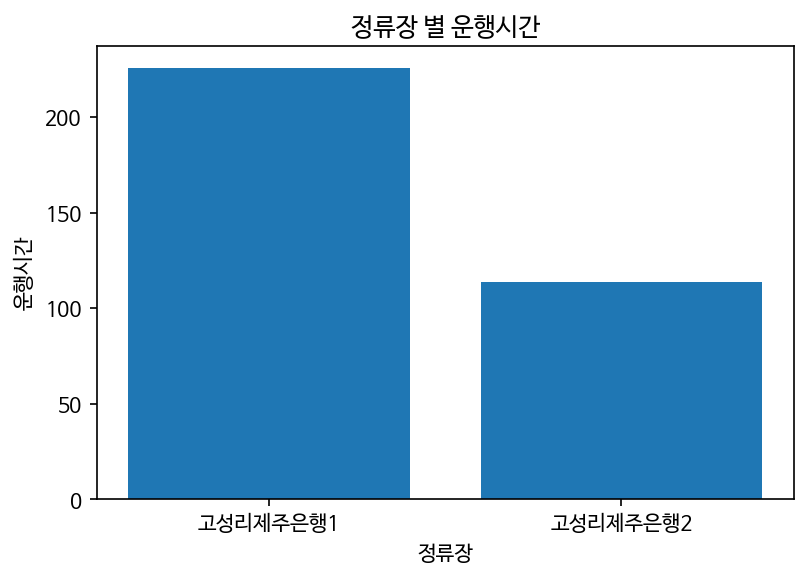

In [ ]:
x = ['고성리제주은행1', '고성리제주은행2']
y = [train[train['now_latitude'] == train[train['now_station'] == '고성리제주은행']['now_latitude'].unique()[0]]['next_arrive_time'].mean(),
     train[train['now_latitude'] == train[train['now_station'] == '고성리제주은행']['now_latitude'].unique()[1]]['next_arrive_time'].mean()]

plt.figure(dpi=150)

plt.title('정류장 별 운행시간')
plt.xlabel('정류장')
plt.ylabel('운행시간')

plt.bar(x,y)
plt.show()

### 5) now_arrive_time

In [ ]:
train['now_arrive_time'].value_counts().sort_index()

00시        5
05시      487
06시     8409
07시    13581
08시    13838
09시    13700
10시    13011
11시    12524
12시    13433
13시    13197
14시    12592
15시    12846
16시    13476
17시    13090
18시    12987
19시    13275
20시    11852
21시    11230
22시     6470
23시      454
Name: now_arrive_time, dtype: int64

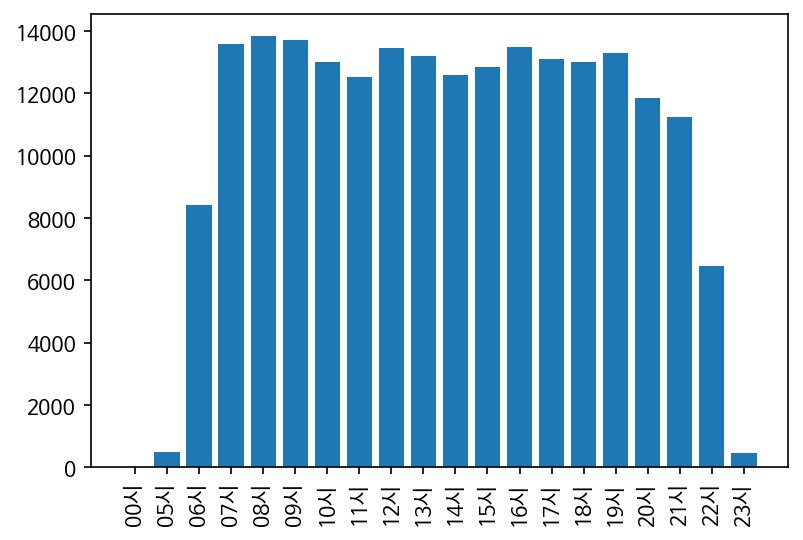

In [ ]:
x = train['now_arrive_time'].value_counts().sort_index().index
y = train['now_arrive_time'].value_counts().sort_index().values

plt.figure(dpi=150)
plt.xticks(rotation=90)

plt.bar(x,y)
plt.show()

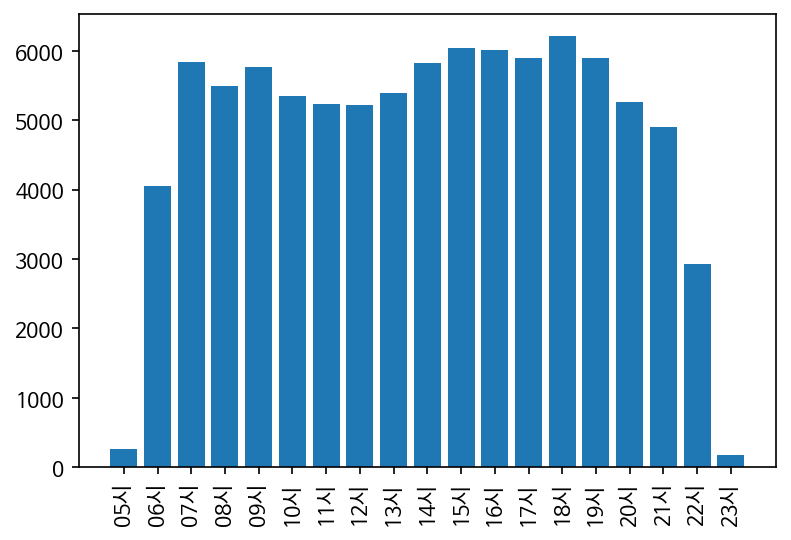

In [ ]:
x = test['now_arrive_time'].value_counts().sort_index().index
y = test['now_arrive_time'].value_counts().sort_index().values

plt.figure(dpi=150)
plt.xticks(rotation=90)

plt.bar(x,y)
plt.show()

분포가 비슷하기때문에 별다른 조치를 취하지 않아도 된다.

### 6) distance

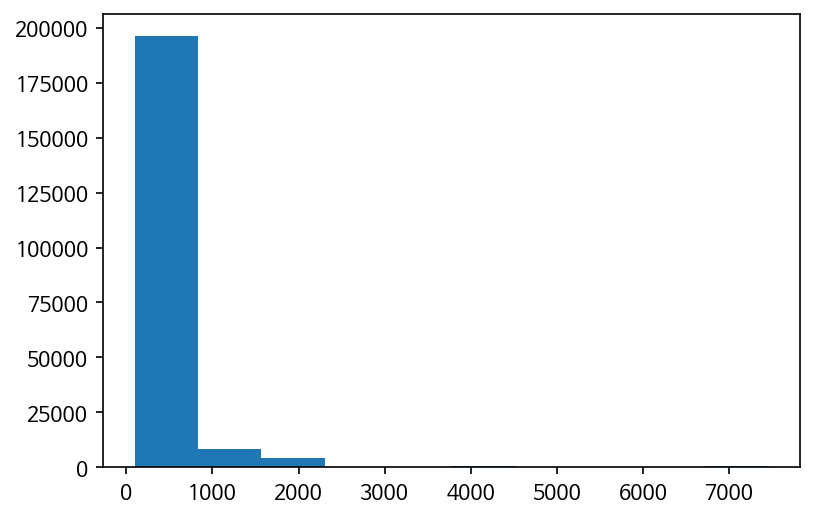

In [ ]:
plt.figure(dpi=150)

plt.hist(train['distance'])
plt.show()

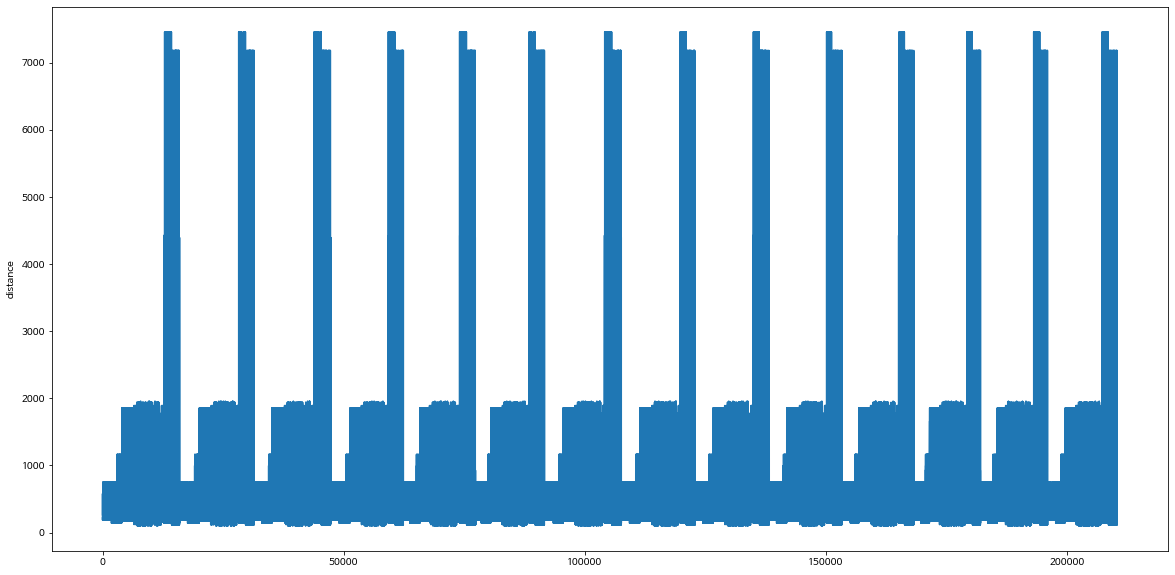

In [ ]:
train['distance'].plot(figsize=(20,10))
plt.ylabel('distance')
plt.show()

In [ ]:
train[train['distance'] > 6000]['now_station'].unique()

array(['성판악', '수악교'], dtype=object)

In [ ]:
train[train['distance'] > 6000]['next_station'].unique()

array(['수악교', '성판악'], dtype=object)

In [ ]:
train[train['distance'] > 6000][[	'now_latitude',	'now_longitude']].iloc[0].values

array([ 33.384634, 126.620353])

In [ ]:
train[train['distance'] > 6000][[	'next_latitude',	'next_longitude']].iloc[0].values

array([ 33.334694, 126.61037 ])

In [ ]:
center = [((train[['now_latitude',	'now_longitude']].loc[1].values[0])+(train[['now_latitude',	'now_longitude']].loc[len(train)-1].values[0]))/2, 
          ((train[['now_latitude',	'now_longitude']].loc[1].values[1])+(train[['now_latitude',	'now_longitude']].loc[len(train)-1].values[1]))/2]

m = folium.Map(location=center, zoom_start=11)

locations = [train[train['distance'] > 6000][[	'now_latitude',	'now_longitude']].iloc[0].values, train[train['distance'] > 6000][[	'next_latitude',	'next_longitude']].iloc[0].values]

folium.PolyLine(locations=locations).add_to(m)

m

산(한라산)을 넘어야하는 버스가 있어서 길이가 긴것

In [ ]:
train[train['distance'] > 6000]['vh_id'].unique()

array([7983416, 7983417, 7983420, 7983431, 7983441, 7983481, 7983482,
       7983484, 7983400, 7983406, 7983409, 7983414, 7983415, 7983430,
       7983432, 7983439, 7983444, 7983445, 7983485, 7983486, 7983402,
       7983483, 7983412, 7983401])

In [ ]:
center = [((train[['now_latitude',	'now_longitude']].loc[1].values[0])+(train[['now_latitude',	'now_longitude']].loc[len(train)-1].values[0]))/2, 
          ((train[['now_latitude',	'now_longitude']].loc[1].values[1])+(train[['now_latitude',	'now_longitude']].loc[len(train)-1].values[1]))/2]

m = folium.Map(location=center, zoom_start=11)

locations = train[(train['vh_id'] == train[train['distance'] > 6000]['vh_id'].unique()[4]) & (train['date'] == '2019-10-16')][['now_latitude',	'now_longitude']].values

folium.PolyLine(locations=locations).add_to(m)

m

## 2.EDA - feature&target

In [ ]:
def change_time(text:str):
  return int(text[:-1])

train['now_arrive_time'] = train['now_arrive_time'].map(change_time)
train

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,temp
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,6,266.0,제대마을,33.457724,126.554014,24,7997025.0
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,6,333.0,제대아파트,33.458783,126.557353,36,7997025.0
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,6,415.0,제주대학교,33.459893,126.561624,40,7997025.0
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),6,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,7997025.0
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,7,374.0,은남동,33.485822,126.490897,64,7997025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,33.255783,126.577450,비석거리,21,528.0,삼아아파트,33.251896,126.574417,96,7983486.0
210453,210453,2019-10-28,405328102,7983486,281-2,33.248595,126.568527,동문로터리,21,280.0,매일올레시장 7번입구,33.249753,126.565959,50,7983486.0
210454,210454,2019-10-28,405328102,7983486,281-2,33.251891,126.560303,서귀포시 구 버스터미널,21,114.0,아랑조을거리 입구,33.251084,126.559551,16,7983486.0
210455,210455,2019-10-28,405328102,7983486,281-2,33.251084,126.559551,아랑조을거리 입구,21,223.0,평생학습관,33.249504,126.558068,38,7983486.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

temp = train.sort_values(by='next_arrive_time')[['now_arrive_time',	'distance',	'next_arrive_time']].reset_index(drop=True)

scaler = MinMaxScaler()

temp[temp.columns] = scaler.fit_transform(temp)
temp

,now_arrive_time,distance,next_arrive_time
0,0.913043,0.000000,0.000000
1,0.521739,0.000000,0.000000
2,0.608696,0.000000,0.000000
3,0.826087,0.000000,0.000000
4,0.391304,0.000000,0.000000
...,...,...,...
210452,0.739130,0.045899,0.969900
210453,0.347826,0.012357,0.969900
210454,0.304348,0.045899,0.977926
210455,0.826087,0.045899,0.989967


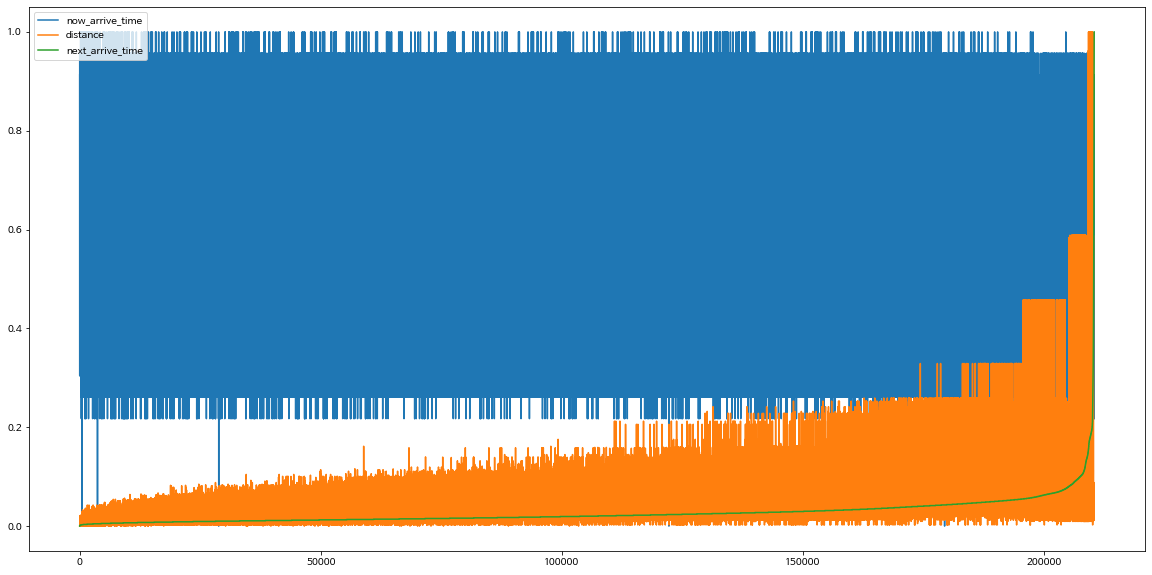

In [ ]:
temp.plot(figsize=(20,10))
plt.show()

## 3.모델링

### 1) 전처리

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/버스/train (1).csv')
test = pd.read_csv('/content/drive/MyDrive/버스/test (1).csv')
submission = pd.read_csv('/content/drive/MyDrive/버스/sample_submission (1).csv')

In [ ]:
train

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,33.255783,126.577450,비석거리,21시,528.0,삼아아파트,33.251896,126.574417,96
210453,210453,2019-10-28,405328102,7983486,281-2,33.248595,126.568527,동문로터리,21시,280.0,매일올레시장 7번입구,33.249753,126.565959,50
210454,210454,2019-10-28,405328102,7983486,281-2,33.251891,126.560303,서귀포시 구 버스터미널,21시,114.0,아랑조을거리 입구,33.251084,126.559551,16
210455,210455,2019-10-28,405328102,7983486,281-2,33.251084,126.559551,아랑조을거리 입구,21시,223.0,평생학습관,33.249504,126.558068,38


In [ ]:
my_list = list(train['vh_id'].unique()) + list(train['now_longitude'].unique()) + list(train['next_longitude'].unique())

In [ ]:
my_dict = {text : i for i, text in enumerate(my_list)}

In [ ]:
def transform_df(df:pd.DataFrame):
  df[['vh_id', 'now_longitude', 'next_longitude']] = df[['vh_id', 'now_longitude', 'next_longitude']].applymap(lambda x:my_dict[x])

  def text_to_time(text:str):
    return int(text[:2])

  df['now_arrive_time'] = df['now_arrive_time'].map(text_to_time)
  
  return df

In [ ]:
train = transform_df(train)
test = transform_df(test)

In [ ]:
train

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,0,360-1,33.456267,702,제주대학교입구,6,266.0,제대마을,33.457724,671,24
1,1,2019-10-15,405136001,0,360-1,33.457724,671,제대마을,6,333.0,제대아파트,33.458783,672,36
2,2,2019-10-15,405136001,0,360-1,33.458783,672,제대아파트,6,415.0,제주대학교,33.459893,673,40
3,3,2019-10-15,405136001,0,360-1,33.479705,705,남국원(아라방면),6,578.0,제주여자중고등학교(아라방면),33.484860,674,42
4,4,2019-10-15,405136001,0,360-1,33.485662,684,도호동,7,374.0,은남동,33.485822,675,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,96,281-2,33.255783,1195,비석거리,21,528.0,삼아아파트,33.251896,993,96
210453,210453,2019-10-28,405328102,96,281-2,33.248595,991,동문로터리,21,280.0,매일올레시장 7번입구,33.249753,980,50
210454,210454,2019-10-28,405328102,96,281-2,33.251891,989,서귀포시 구 버스터미널,21,114.0,아랑조을거리 입구,33.251084,988,16
210455,210455,2019-10-28,405328102,96,281-2,33.251084,988,아랑조을거리 입구,21,223.0,평생학습관,33.249504,987,38


# EDA

## 인사이트!

#### 1.요일을 추출하면 예측하는데 더 도움이 되지않을까?

In [ ]:
train['week'] = pd.to_datetime(train['date']).dt.dayofweek

In [ ]:
test['week'] = pd.to_datetime(test['date']).dt.dayofweek

모델로 예측해본 결과: 상관관계가 좋자읺다. RMSE가 더 안좋았다. - 실패

#### 2.그렇다면 요일중에서도 주말과 평일의 next_arrive_time의 차이가 있지 않을까?

In [ ]:
weekend = train[(train['week'] == 6) | (train['week'] == 7)] # 일요일과 토요일 -> 주말을 나타내는 데이터 프레임

In [ ]:
weekday = train[(train['week'] != 6) & (train['week'] != 7)] # 일요일과 토요일 아닌 -> 평일을 나타내는 데이터 프레임

In [ ]:
weekend.mean().next_arrive_time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


82.71473154124406

In [ ]:
weekday.mean().next_arrive_time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


85.79330513170818

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


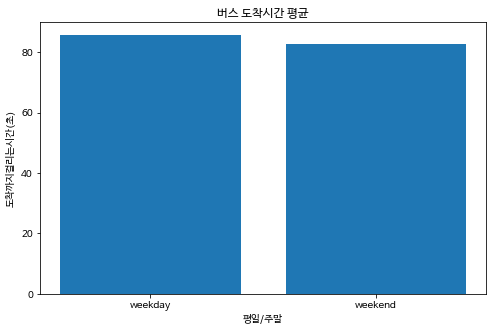

In [ ]:
x = ['weekday', 'weekend']
y = [weekday.mean().next_arrive_time, weekend.mean().next_arrive_time]

plt.figure(figsize = (8,5))
plt.title("버스 도착시간 평균")
plt.xlabel('평일/주말')
plt.ylabel('도착까지걸리는시간(초)')
plt.bar(x, y)
plt.show()

차이가 거의 없었다. 사용x

#### 3.출근시간과 출근외의 시간에 next_arrive_time의 차이가 있지 않을까?

In [ ]:
work = train[(train['now_arrive_time'] == 7) | (train['now_arrive_time'] == 8) | (train['now_arrive_time'] == 9) | (train['now_arrive_time'] == 17) | (train['now_arrive_time'] == 18) | (train['now_arrive_time'] == 19)]

In [ ]:
notwork = train[(train['now_arrive_time'] != 7) & (train['now_arrive_time'] != 8) & (train['now_arrive_time'] != 9) & (train['now_arrive_time'] != 17) & (train['now_arrive_time'] != 18) & (train['now_arrive_time'] != 19)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


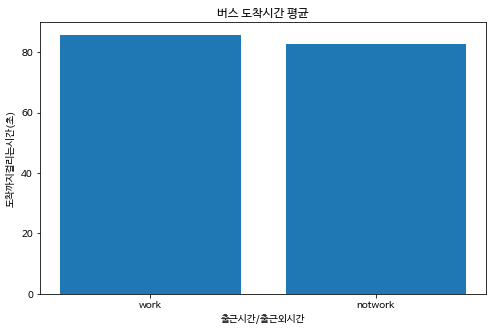

In [ ]:
x = ['work', 'notwork']
y = [weekday.mean().next_arrive_time, weekend.mean().next_arrive_time]

plt.figure(figsize = (8,5))
plt.title("버스 도착시간 평균")
plt.xlabel('출근시간/출근외시간')
plt.ylabel('도착까지걸리는시간(초)')
plt.bar(x, y)
plt.show()

별 차이가 없다. 사용x

#### 4.now_arrive_time에서 24시가 0으로 표시되어있는데 24로 표시해주면 더 예측을 높이지 않을까?(오후 11시는 23으로 표시되어있다)

In [ ]:
# train=train.replace({'now_arrive_time':0},24)
# train[train['now_arrive_time']==24]

In [ ]:
# test=test.replace({'now_arrive_time':0},24)

모델로 예측해본 결과: RMSE가 더 안좋았다. - 실패

#### 5.거리와 현재 도착한 시간

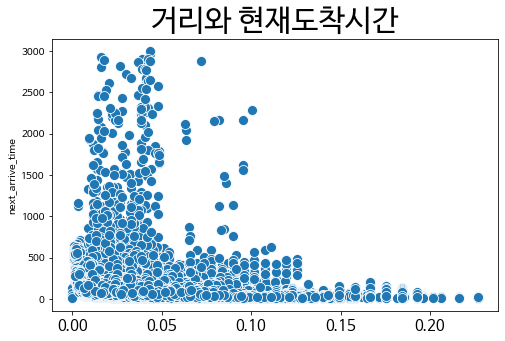

In [ ]:
from seaborn.relational import scatterplot
import seaborn as sns 

dn = train['now_arrive_time'] / train['distance']

plt.figure(figsize=(8,5))
sns.scatterplot(x=dn, y=train['next_arrive_time'], s = 100 )
plt.xticks(fontsize=15)
plt.title('거리와 현재도착시간', fontsize = 30)
plt.show()

In [ ]:
train['dn'] = train['distance'] / train['now_arrive_time']

In [ ]:
test['dn'] = test['distance'] / test['now_arrive_time']

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


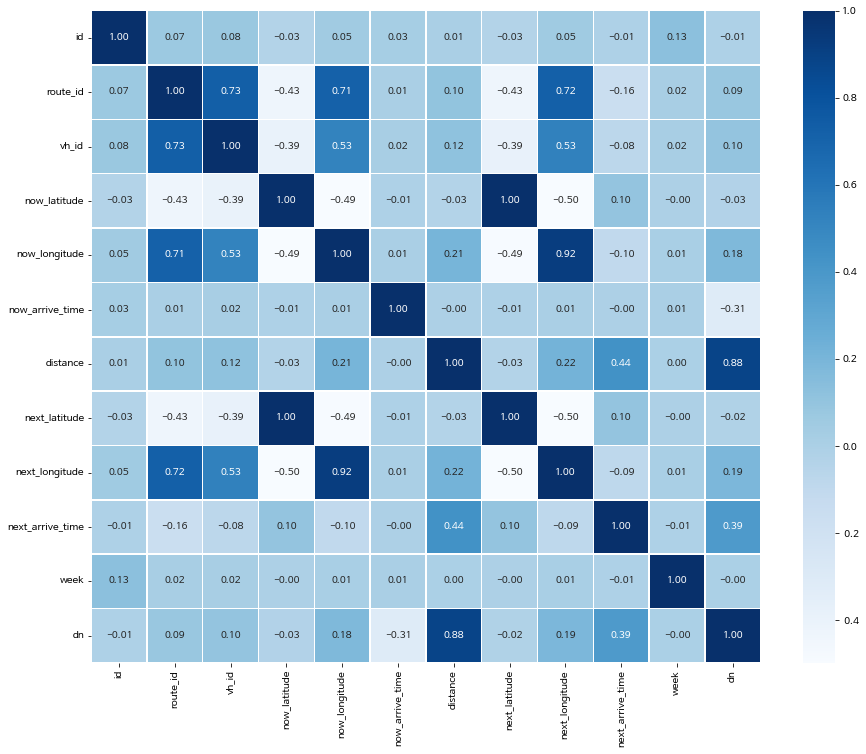

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(data = train.corr(method='pearson'), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

모델로 예측해본 결과: RMSE가 더 안좋았다. - 실패

#### 6.현재경도와 다음경도의 차이가 클수록 next_arrive_time의 차이가 크지않을까?

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


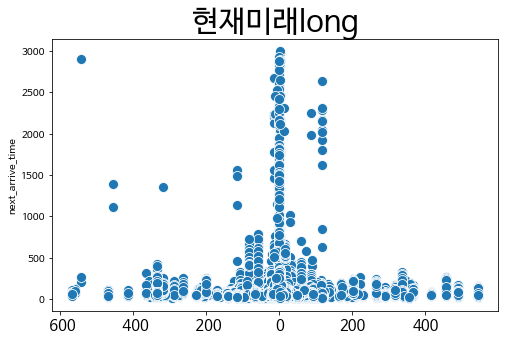

In [ ]:
import seaborn as sns 
from seaborn.relational import scatterplot
nl = train['now_longitude'] - train['next_longitude']

plt.figure(figsize=(8,5))
sns.scatterplot(x=nl, y=train['next_arrive_time'], s = 100 )
plt.xticks(fontsize=15)
plt.title('현재미래long', fontsize = 30)
plt.show()

In [ ]:
train['nl'] = train['now_longitude'] - train['next_longitude']

In [ ]:
test['nl'] = test['now_longitude'] - test['next_longitude']

음이나 양의 상관관계를 보이지 않는다.  
next_arrive_time와의 상관관계가 좋지않다.

이것 역시 RMSE가 더 안좋았다. - 실패

## Feature Engineering

#### 1.비닝: 거리

In [ ]:
train['distance'].value_counts().sort_index()

97.0       315
110.0        6
114.0     1418
120.0      142
134.0      281
          ... 
3469.0      89
4397.0     464
4429.0     344
7185.0     340
7461.0     248
Name: distance, Length: 414, dtype: int64

In [ ]:
train['distance'].value_counts().sort_values()

1287.0       3
1367.0       3
1545.0       5
781.0        5
110.0        6
          ... 
244.0     2486
291.0     2487
355.0     2544
578.0     3240
374.0     3456
Name: distance, Length: 414, dtype: int64

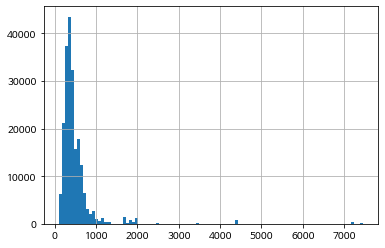

In [ ]:
train['distance'].hist(bins=100)

In [ ]:
bins=[0,200,400,600,800,1000,1200,1400,1600,1800,2000,8000]
bins_time = [1,2,3,4,5,6,7,8,9,10,11]
train['distance_bins'] = pd.cut(train['distance'],bins=bins,labels=bins_time, include_lowest=True)

In [ ]:
# 이 방법으로 시도해봤다.

# bins=[0,2000,8000]
# bins_time = [0,1]
# train['distance_bins'] = pd.cut(train['distance'],bins=bins,labels=bins_time, include_lowest=True)

In [ ]:
train['distance_bins']=train['distance_bins'].astype(int)

In [ ]:
test['distance_bins'] = pd.cut(test['distance'],bins=bins,labels=bins_time, include_lowest=True)
test['distance_bins']=test['distance_bins'].astype(int)

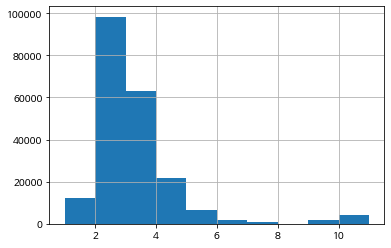

In [ ]:
train['distance_bins'].hist()

더 안좋은 RMSE값이 도출됐다. - 실패

#### 2.거리에 로그 씌어주기

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


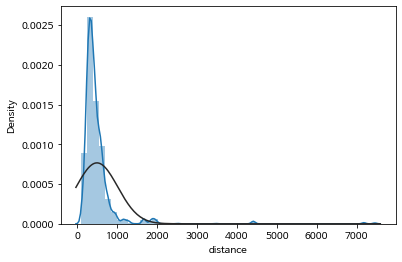

In [ ]:
from scipy import stats
import numpy as np

sns.distplot(train['distance'], fit=stats.norm)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


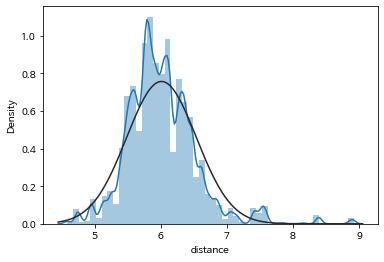

In [ ]:
sns.distplot(np.log1p(train['distance']), fit=stats.norm)

In [ ]:
import numpy as np
# train['distance']=np.log1p(train['distance'])
# test['distance']=np.log1p(test['distance'])

그래프가 정규분포와 가까워지기에 예측했을 때 더 좋은 값이 나올 것이라 추측했으나, 변화가 없었다.

#### 3.거리 스켈링

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


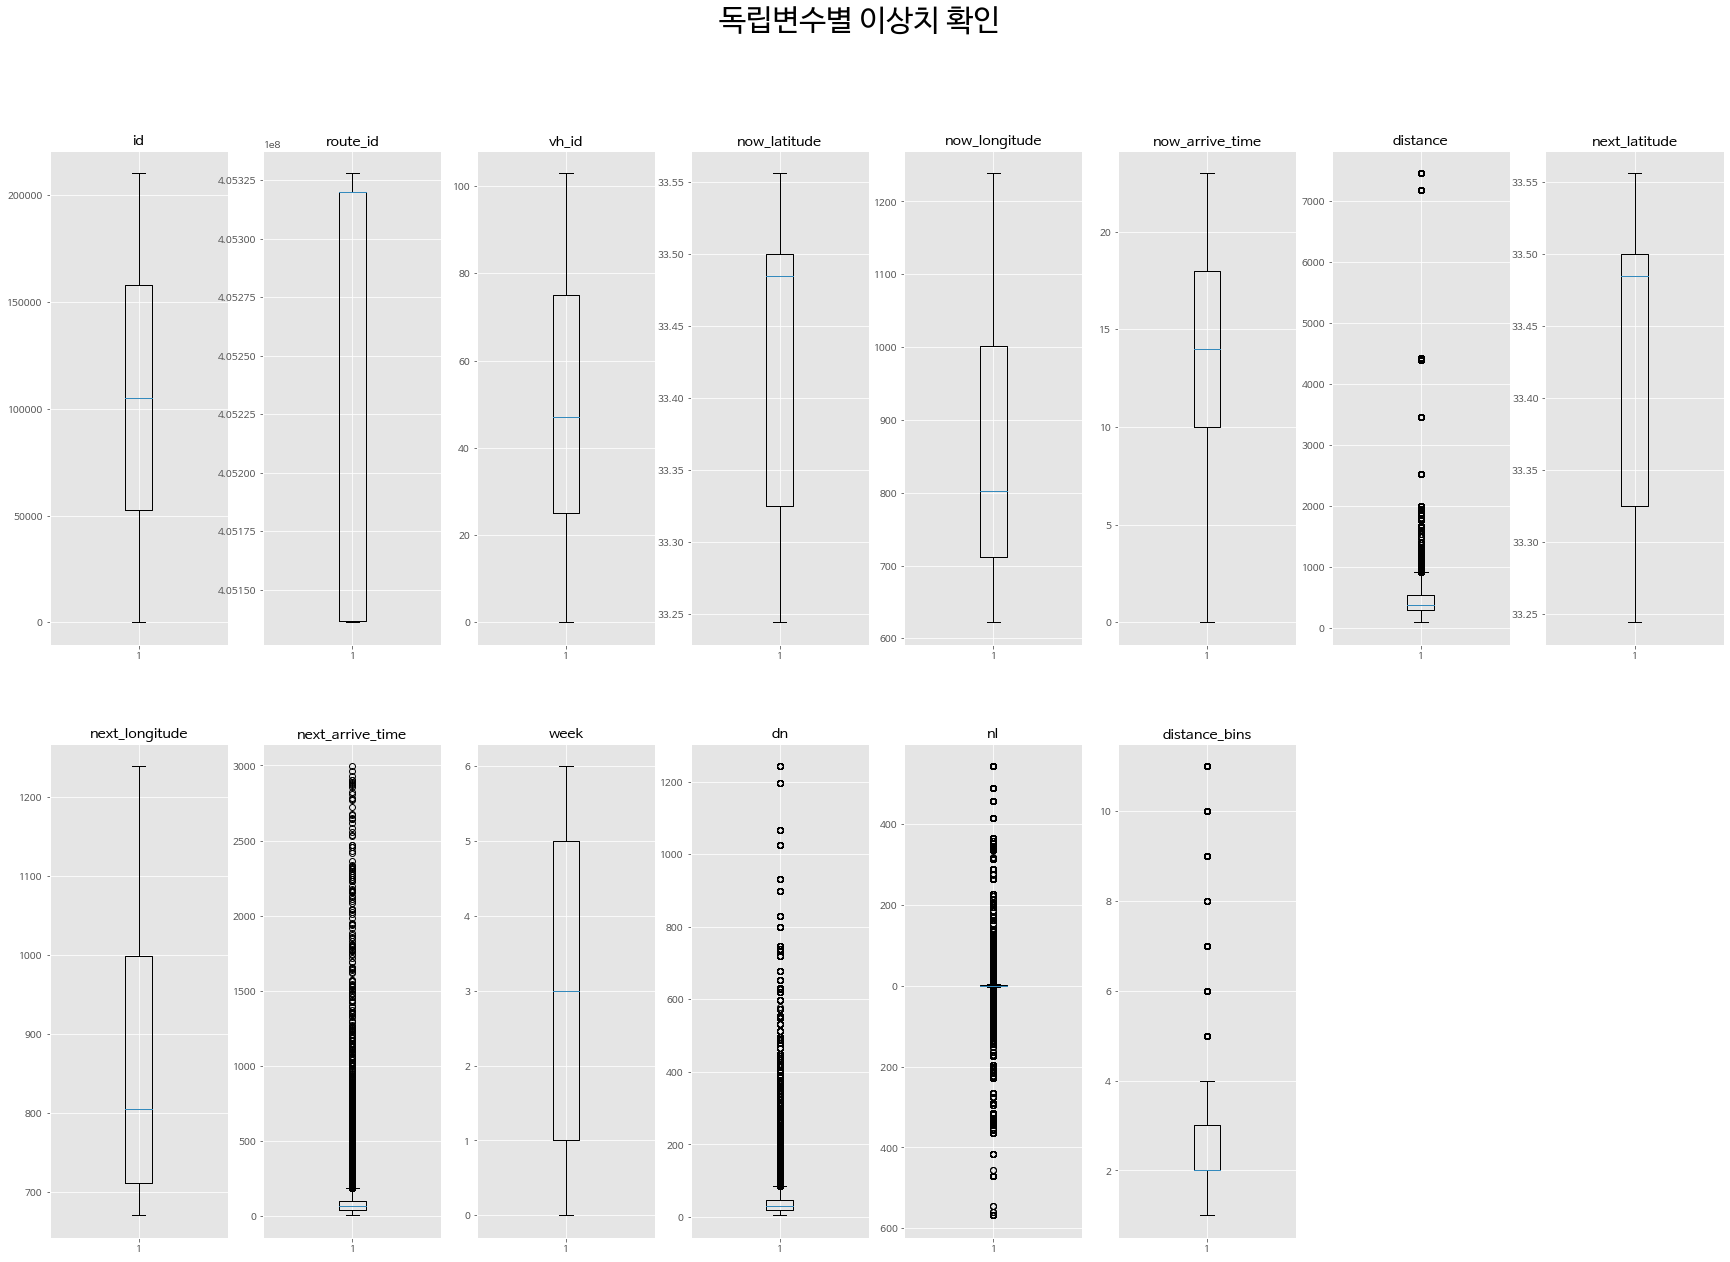

In [ ]:
plt.style.use('ggplot')

feature = train.describe().columns

plt.figure(figsize = (30,20))
plt.suptitle('독립변수별 이상치 확인',fontsize=30)

for i in range(len(feature)):
  plt.subplot(2,8,i+1)
  plt.title(feature[i])
  plt.boxplot(train[feature[i]])

plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train[['distance']])

scaled = scaler.transform(train[['distance']])

train[['Scaled_distance']] = scaled

train

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,week,dn,nl,distance_bins,Scaled_distance
0,0,2019-10-15,405136001,0,360-1,33.456267,702,제주대학교입구,6,266.0,제대마을,33.457724,671,24,1,44.333333,31,2,0.022949
1,1,2019-10-15,405136001,0,360-1,33.457724,671,제대마을,6,333.0,제대아파트,33.458783,672,36,1,55.500000,-1,2,0.032048
2,2,2019-10-15,405136001,0,360-1,33.458783,672,제대아파트,6,415.0,제주대학교,33.459893,673,40,1,69.166667,-1,3,0.043183
3,3,2019-10-15,405136001,0,360-1,33.479705,705,남국원(아라방면),6,578.0,제주여자중고등학교(아라방면),33.484860,674,42,1,96.333333,31,3,0.065318
4,4,2019-10-15,405136001,0,360-1,33.485662,684,도호동,7,374.0,은남동,33.485822,675,64,1,53.428571,9,2,0.037615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,96,281-2,33.255783,1195,비석거리,21,528.0,삼아아파트,33.251896,993,96,0,25.142857,202,3,0.058528
210453,210453,2019-10-28,405328102,96,281-2,33.248595,991,동문로터리,21,280.0,매일올레시장 7번입구,33.249753,980,50,0,13.333333,11,2,0.024851
210454,210454,2019-10-28,405328102,96,281-2,33.251891,989,서귀포시 구 버스터미널,21,114.0,아랑조을거리 입구,33.251084,988,16,0,5.428571,1,1,0.002309
210455,210455,2019-10-28,405328102,96,281-2,33.251084,988,아랑조을거리 입구,21,223.0,평생학습관,33.249504,987,38,0,10.619048,1,2,0.017110


In [ ]:
scaled = scaler.transform(test[['distance']])

test[['Scaled_distance']] = scaled

이것 역시 RMSE값이 처음 코드와 동일한 값이 나왔다. 변화x

### 상관관계

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


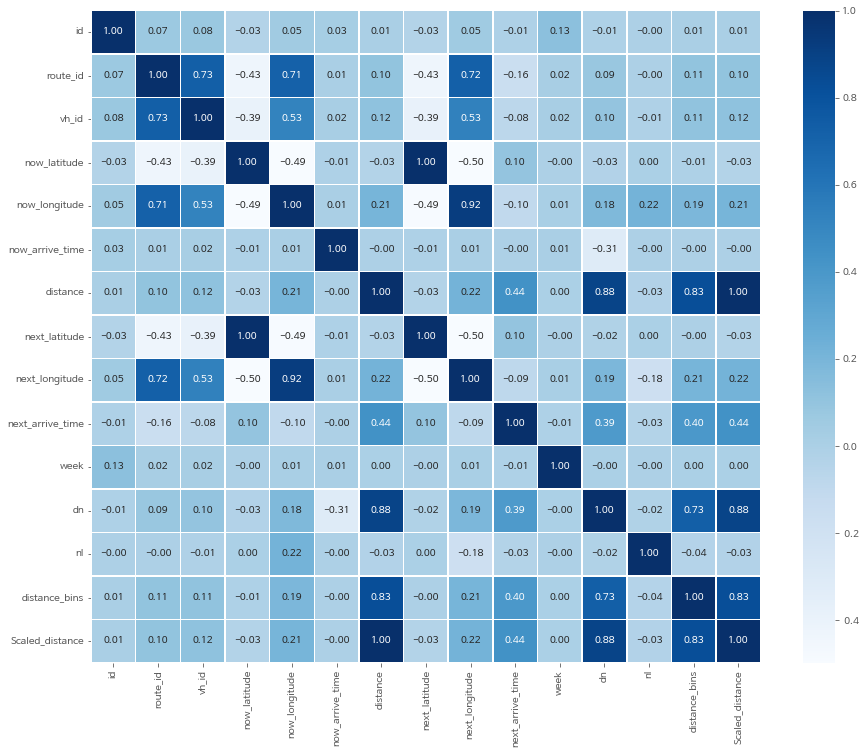

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(data = train.corr(method='pearson'), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

## 이상치와 피쳐

In [ ]:
train = train[train['next_arrive_time'] <= 1000]

In [ ]:
features = ['vh_id', 'now_longitude', 'now_arrive_time', 'distance', 'next_longitude']
target = 'next_arrive_time'

In [ ]:
X = train[features]

In [ ]:
y = train[target]

### 2) validation셋 구축

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.1, shuffle=False)

In [ ]:
X_train

,vh_id,now_longitude,now_arrive_time,distance,next_longitude
0,0,702,6,266.0,671
1,0,671,6,333.0,672
2,0,672,6,415.0,673
3,0,705,6,578.0,674
4,0,684,7,374.0,675
...,...,...,...,...,...
189407,47,1092,20,1070.0,1069
189408,47,1069,20,834.0,1119
189409,47,1119,20,571.0,805
189410,47,805,20,315.0,1094


In [ ]:
X_valid

,vh_id,now_longitude,now_arrive_time,distance,next_longitude
189412,47,1032,20,417.0,1033
189413,47,1034,20,588.0,1035
189414,47,1035,20,992.0,1036
189415,47,1067,20,407.0,1037
189416,47,1037,20,249.0,953
...,...,...,...,...,...
210452,96,1195,21,528.0,993
210453,96,991,21,280.0,980
210454,96,989,21,114.0,988
210455,96,988,21,223.0,987


### 3) 랜덤포레스트 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(pred, real):
  return mean_squared_error(pred, real)**0.5

In [ ]:
def make_plot():
  RMSE = rmse(y_pred, y_valid)

  plt.figure(dpi=150)

  plt.title('RMSE : ' + str(RMSE)[:8])

  plt.plot(y_valid.reset_index(drop=True), alpha=0.6, label='real')
  plt.plot(y_pred, alpha=0.6, label='pred')

  plt.legend()
  plt.show()

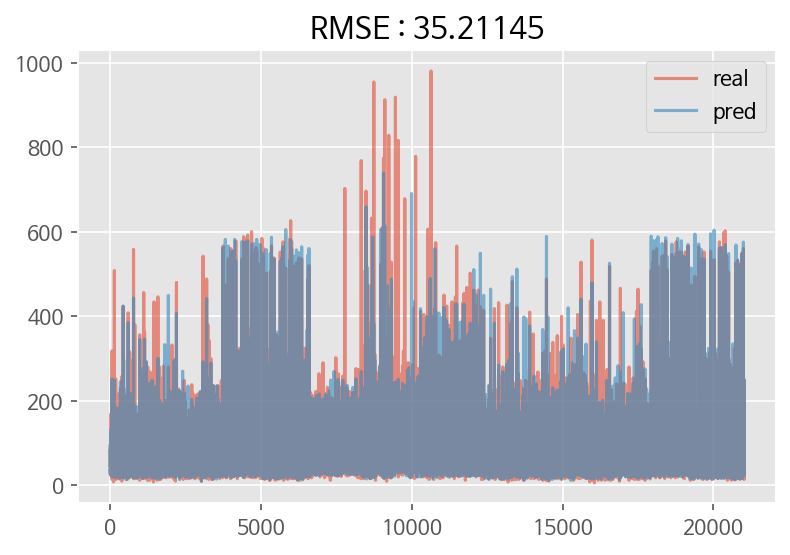

In [ ]:
make_plot()

### 4) xgboost 모델

In [ ]:
import xgboost as xgb

# model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 3000)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 3000, tree_method='gpu_hist')

model.fit(X_train,y_train, eval_set=[(X_valid,y_valid)],
          eval_metric = 'rmse',
          early_stopping_rounds=10,
          verbose=5
          )

y_pred = model.predict(X_valid)

[0]	validation_0-rmse:95.3219
Will train until validation_0-rmse hasn't improved in 10 rounds.
[5]	validation_0-rmse:68.2565
[10]	validation_0-rmse:55.3815
[15]	validation_0-rmse:49.8475
[20]	validation_0-rmse:47.3265
[25]	validation_0-rmse:46.0695
[30]	validation_0-rmse:45.2887
[35]	validation_0-rmse:44.4669
[40]	validation_0-rmse:43.7149
[45]	validation_0-rmse:43.1887
[50]	validation_0-rmse:42.5501
[55]	validation_0-rmse:42.3398
[60]	validation_0-rmse:41.9109
[65]	validation_0-rmse:41.6858
[70]	validation_0-rmse:41.4197
[75]	validation_0-rmse:41.0868
[80]	validation_0-rmse:40.7737
[85]	validation_0-rmse:40.5006
[90]	validation_0-rmse:40.3133
[95]	validation_0-rmse:40.0851
[100]	validation_0-rmse:39.806
[105]	validation_0-rmse:39.6798
[110]	validation_0-rmse:39.3748
[115]	validation_0-rmse:39.2297
[120]	validation_0-rmse:39.0966
[125]	validation_0-rmse:38.9519
[130]	validation_0-rmse:38.7606
[135]	validation_0-rmse:38.6538
[140]	validation_0-rmse:38.5386
[145]	validation_0-rmse:38.424

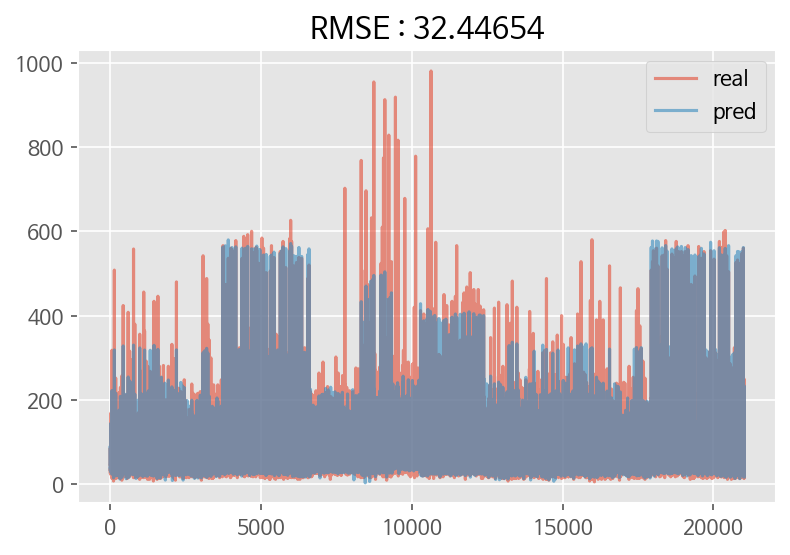

In [ ]:
make_plot()

### 5) catboost 모델

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
X_train

,vh_id,now_longitude,now_arrive_time,distance,next_longitude
0,0,702,6,266.0,671
1,0,671,6,333.0,672
2,0,672,6,415.0,673
3,0,705,6,578.0,674
4,0,684,7,374.0,675
...,...,...,...,...,...
189407,47,1092,20,1070.0,1069
189408,47,1069,20,834.0,1119
189409,47,1119,20,571.0,805
189410,47,805,20,315.0,1094


In [ ]:
cat_features = [0,1,4]

In [ ]:
model = CatBoostRegressor(n_estimators = 6000,task_type='GPU')

model.fit(X_train, y_train,
          eval_set=(X_valid,y_valid),
          cat_features=cat_features,
          use_best_model=True,
          verbose=True
          )

y_pred = model.predict(X_valid)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1003:	learn: 33.3193949	test: 32.0925224	best: 32.0918140 (1001)	total: 17.8s	remaining: 1m 28s
1004:	learn: 33.3186120	test: 32.0931137	best: 32.0918140 (1001)	total: 17.8s	remaining: 1m 28s
1005:	learn: 33.3182732	test: 32.0930914	best: 32.0918140 (1001)	total: 17.8s	remaining: 1m 28s
1006:	learn: 33.3177403	test: 32.0930084	best: 32.0918140 (1001)	total: 17.9s	remaining: 1m 28s
1007:	learn: 33.3163978	test: 32.0922408	best: 32.0918140 (1001)	total: 17.9s	remaining: 1m 28s
1008:	learn: 33.3159854	test: 32.0924008	best: 32.0918140 (1001)	total: 17.9s	remaining: 1m 28s
1009:	learn: 33.3145057	test: 32.0924942	best: 32.0918140 (1001)	total: 17.9s	remaining: 1m 28s
1010:	learn: 33.3125387	test: 32.0919666	best: 32.0918140 (1001)	total: 17.9s	remaining: 1m 28s
1011:	learn: 33.3111960	test: 32.0891507	best: 32.0891507 (1011)	total: 18s	remaining: 1m 28s
1012:	learn: 33.3101972	test: 32.0882851	best: 32.0882851 (1012)	total: 18s	remaining: 1m 28s
1013:	le

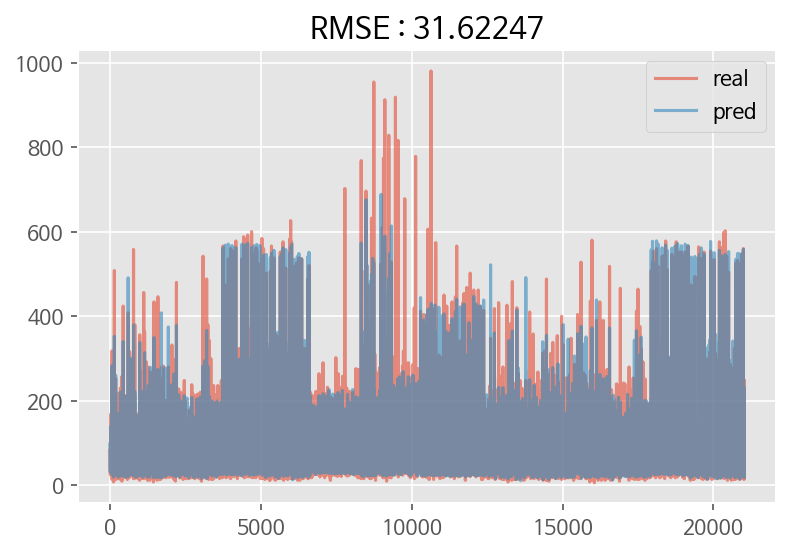

In [ ]:
make_plot()

In [ ]:
model = CatBoostRegressor(n_estimators = 6000,task_type='GPU')

model.fit(X_train, y_train,
          eval_set=(X_valid,y_valid),
          cat_features=cat_features,
          use_best_model=True,
          verbose=True
          )

y_pred = model.predict(test[features])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1003:	learn: 33.3193949	test: 32.0925224	best: 32.0918140 (1001)	total: 18s	remaining: 1m 29s
1004:	learn: 33.3186120	test: 32.0931137	best: 32.0918140 (1001)	total: 18s	remaining: 1m 29s
1005:	learn: 33.3182732	test: 32.0930914	best: 32.0918140 (1001)	total: 18s	remaining: 1m 29s
1006:	learn: 33.3177403	test: 32.0930084	best: 32.0918140 (1001)	total: 18s	remaining: 1m 29s
1007:	learn: 33.3163978	test: 32.0922408	best: 32.0918140 (1001)	total: 18.1s	remaining: 1m 29s
1008:	learn: 33.3159854	test: 32.0924008	best: 32.0918140 (1001)	total: 18.1s	remaining: 1m 29s
1009:	learn: 33.3145057	test: 32.0924942	best: 32.0918140 (1001)	total: 18.1s	remaining: 1m 29s
1010:	learn: 33.3125387	test: 32.0919666	best: 32.0918140 (1001)	total: 18.1s	remaining: 1m 29s
1011:	learn: 33.3111960	test: 32.0891507	best: 32.0891507 (1011)	total: 18.1s	remaining: 1m 29s
1012:	learn: 33.3101972	test: 32.0882851	best: 32.0882851 (1012)	total: 18.1s	remaining: 1m 29s
1013:	learn:

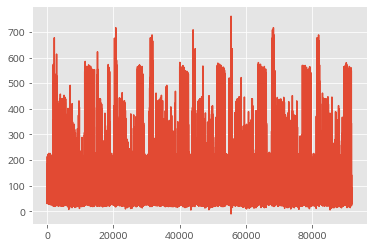

In [ ]:
plt.plot(y_pred)
plt.show()

In [ ]:
submission[target] = y_pred
submission.to_csv('submission_1.csv', index=False)